# Section 4: Statistical Models

In Section 4, you will look at statistical models in the context of election polling and forecasting.

After completing Section 4, you will be able to:

- Understand how aggregating data from different sources, as poll aggregators do for poll data, can improve the precision of a prediction.
- Understand how to fit a multilevel model to the data to forecast, for example, election results.
- Explain why a simple aggregation of data is insufficient to combine results because of factors such as pollster bias.
- Use a data-driven model to account for additional types of sampling variability such as pollster-to-pollster variability.

There is 1 assignment that uses the DataCamp platform for you to practice your coding skills.

We encourage you to use R to interactively test out your answers and further your learning.

In [47]:
using Statistics
using Distributions
using StatsBase
using DataFrames
using RDatasets
using Dates
using StatsPlots
using Plots

We start by defining the usual functions from R: `pnorm` and `qnorm`.

In [3]:
# Define the pnorm from R.
pnorm(x::Number) = cdf(Normal(0, 1), x);
# Define the qnorm from R.
qnorm(x::Number) = quantile(Normal(0, 1), x);

## Poll Aggregators

### Defining the functions to compute the Monte Carlo simulation to generate the data

We use a multiple dispatch approach to create the data related to confidence intervals.

We start by creating a function which receives a value $N$ from a vector of integers and a value of probability $p$.

Next we create the same function but now it will receive the whole vector of values $N_s$ and will do the computing using a MapReduce approach to concatenate all the results from evaluating the whole vector $N_s$ and transpose the matrix so we can create a table to elements $\#N_s$

Finally we use the previous function to generate 3 data frames. One which will have the row number of the data, the data, and the sample sizes. We concatenate the 3 of them horizontally and have the final data frame which will be the result of our Monte Carlo Simulation.

In [4]:
function confidenceIntervals(N::Int, p::Float64)::Vector{Float64}
    X = sample([0, 1], Weights([1 - p, p]), N)
    X̂ = mean(X)
    SÊ = sqrt(X̂ * (1 - X̂) / N)
    return 2 * [X̂, X̂ - 2 * SÊ, X̂ + 2 * SÊ] .- 1
end

function confidenceIntervals(Nₛ::Vector{Int}, p::Float64)::Matrix{Float64}
    data = map(N -> confidenceIntervals(N, p), Nₛ)
    return reduce(hcat, data) |> transpose
end

function createDataFrame(Nₛ::Vector{Int}, p::Float64)::DataFrame
    n = length(Nₛ)
    polls = DataFrame(poll = 1:n)
    sampleSize = DataFrame(sample_size = Nₛ)
    data = confidenceIntervals(Nₛ, p)
    names = [:estimate, :low, :high]
    df = DataFrame(data, names)
    dfList = [polls, df, sampleSize]
    return reduce(hcat, dfList)
end

createDataFrame (generic function with 1 method)

### Define the data for the experiment

Now we define the data for the experiment.

In [5]:
d = 0.039
Nₛ = [1298, 533, 1342, 897, 774, 254, 812, 324, 1291, 1056, 2172, 516]
p = (d + 1) / 2
polls = createDataFrame(Nₛ, p)

Row,poll,estimate,low,high,sample_size
,Int64,Float64,Float64,Float64,Int64
1,1,0.0354391,-0.0200387,0.090917,1298
2,2,0.0731707,-0.0132267,0.159568,533
3,3,0.0268256,-0.0277498,0.0814011,1342
4,4,0.090301,0.0237958,0.156806,897
5,5,0.0878553,0.0162448,0.159466,774
6,6,0.0551181,-0.0701823,0.180419,254
7,7,0.0935961,0.0237179,0.163474,812
8,8,0.0864198,-0.0242757,0.197115,324
9,9,0.02866,-0.0269802,0.0843001,1291


Now compute the *weighted average* and other stuff considering the following:
- Sample size: $N_i$
- Estimated: $\hat{X}_i$
- Weighted average: $\hat{d}$
- Margin of error: $\mu_e$
- Confidence coefficient for $\alpha$ (equal to $5\%$): $Z_{\alpha/2}$
$$
\begin{align*}
    \hat{d} & = \frac{\sum_{i}\hat{X}_i \cdot N_i}{\sum_{i}N_i}, \\
    \hat{p} & = \frac{1 + \hat{d}}{2}, \\
    \mu_e & = 2 \cdot Z_{\alpha/2} \cdot \sqrt{\frac{\hat{p}(1 - \hat{p})}{\sum_{i}N_i}}
\end{align*}
$$

In [6]:
d̂ = sum(polls.estimate .* polls.sample_size) / sum(polls.sample_size)
# Two variants with dot product are:
# Using directly `transpose`
# d̂ = transpose(polls.estimate) * polls.sample_size / sum(polls.sample_size)
# Using the adjoint operator '
# d̂ = polls.estimate' * polls.sample_size / sum(polls.sample_size)
p̂ = (1 + d̂) / 2
α = 0.05
confidence = 1 - α/2
μₑ = 2 * qnorm(confidence) * sqrt(p̂ * (1 - p̂) / sum(polls.sample_size))
println(" >>> d̂ = ", round(d̂ * 100, digits = 1))
println(" >>> μₑ = ", round(μₑ * 100, digits = 1))
avgInterval = [d̂ - μₑ, d̂ + μₑ];
println(" >>> average interval (d̂ - μₑ, d̂ + μₑ): ", avgInterval)

 >>> d̂ = 4.0
 >>> μₑ = 1.8
 >>> average interval (d̂ - μₑ, d̂ + μₑ): 

[0.021750565959742497, 0.058646984843345615]


## Poll Data and Pollster Bias

The csv file can be downloaded from [here](https://vincentarelbundock.github.io/Rdatasets/csv/dslabs/polls_us_election_2016.csv).

We will consider the following key points:

- We analyze real 2016 US polling data organized by FiveThirtyEight. We start by using reliable national polls taken within the week before the election to generate an urn model.
- Consider $p$ the proportion voting for Clinton and $1 - p$ the proportion voting for Trump. We are interested in the spread $d = 2p - 1$.
- Poll results are a random normal variable with expected value of the spread $d$ and standard error $2\sqrt{p(1 - p) / N}$.
- Our initial estimate of the spread did not include the actual spread. Part of the reason is that different pollsters have different numbers of polls in our dataset, and each pollster has a bias.
- *Pollster* bias reflects the fact that repeated polls by a given pollster have an expected value different from the actual spread and different from other pollsters. Each pollster has a different bias.
- The urn model does not account for pollster bias. We will develop a more flexible data-driven model that can account for effects like bias.

Now we will proceed to generate simulated poll data:

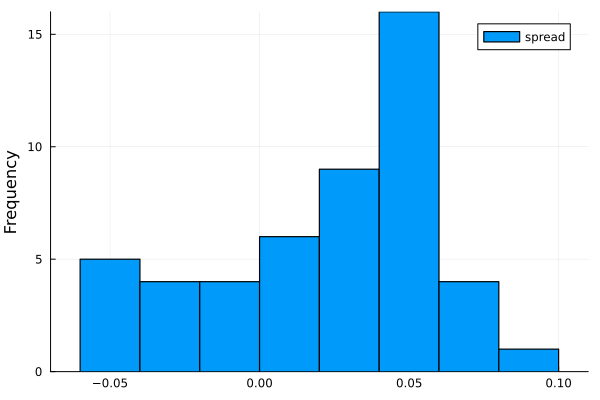

In [7]:
pollsUsElection2016 = dataset("dslabs", "polls_us_election_2016");
polls = filter(row -> row[:state] == "U.S." &&
                      row[:enddate] >= Date("2016-10-31") &&
                      (row[:grade] ∈ ["A+", "A", "A-", "B+"] || row[:grade] == "" ),
               pollsUsElection2016);
polls.spread = (polls.rawpoll_clinton - polls.rawpoll_trump) / 100;
polls.samplesize = map(n -> parse(Int, n), polls.samplesize)
N = sum(polls.samplesize)
d̂ = (polls.spread' * polls.samplesize) / N
p̂ = (d̂ + 1) / 2
α = 0.05
confidence = 1 - α / 2
μₑ = qnorm(confidence) * 2 * sqrt(p̂ * (1 - p̂) / N)
plotHistogram = histogram(polls.spread, bins=:auto, binwidth = 0.01, linecolor="black", linewidth=1.2,
                          label="spread", ylabel="Frequency")

Now we want to focus our attention with the pollsters that have participated at least 6 times and plot their spread: 

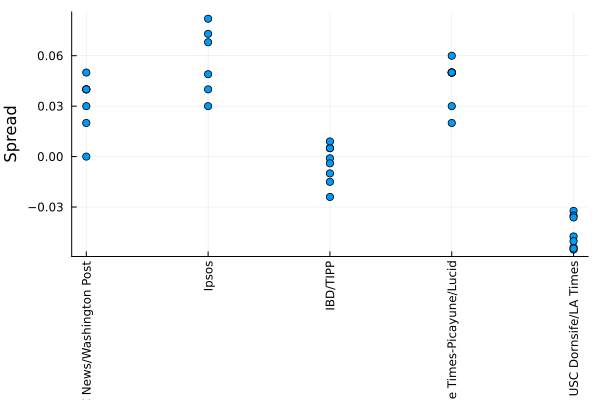

In [34]:
groupby(polls, :pollster) |>
    grouped -> filter(gdf -> nrow(gdf) >= 6, grouped) |>
    grouped -> reduce(vcat, grouped) |>
    df -> scatter(df.pollster, df.spread, xrotation=90, legend=false,
                  xlabel="Pollster", ylabel="Spread")

Now we will obtain the standard errors within each pollster:

In [9]:
groupby(polls, :pollster) |>
    grouped -> filter(subDf -> nrow(subDf) >= 6, grouped) |>
    grouped -> combine(grouped, :samplesize => (s -> 2 * sqrt(p̂ * (1 - p̂) / median(s))) => :se)

Row,pollster,se
,String,Float64
1,ABC News/Washington Post,0.0265439
2,Ipsos,0.0225194
3,IBD/TIPP,0.0333207
4,The Times-Picayune/Lucid,0.0196399
5,USC Dornsife/LA Times,0.0183183


## Data Driven Models

Here are some key points to consider:

- Instead of using an urn model where each poll is a random draw from the same distribution of voters, we instead define a model using an urn that contains poll results from all possible pollsters.
- We assume the expected value of this model is the actual spread $d = 2p - 1$.
- Our new standard error $\sigma$ now factors in pollster-to-pollster variability. It can no longer be calculated from $p$ or $d$ and is an unknown parameter.
- The central limit theorem still works to estimate the sample average of many polls $X_1, \dots, X_N$ because the average of the sum of many random variables is a normally distributed random variable with expected value $d$ and standard error $\sigma / \sqrt{N}$.
- We can estimate the unobserved $\sigma$ as the sample standard deviation, which is calculated with the `std` function.

We start by collecting the last result before the election for each pollster.

In [40]:
onePollPerPollster = groupby(polls, :pollster) |>
    grouped -> combine(grouped,
                       subDf -> filter(row -> row[:enddate] == max(subDf.enddate...), subDf));

Next we create a histogram of the spread estimates

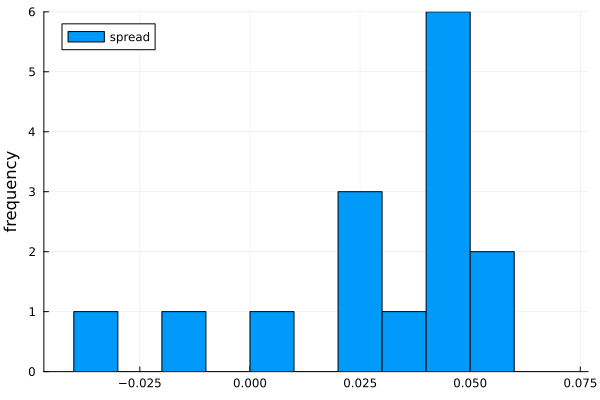

In [45]:
histogram(onePollPerPollster.spread, bins = :auto, binwidth = 0.01,
          label = "spread", ylabel = "frequency")

Now we construct a 95% confidence interval considering the sample standard deviation:
$$
    s = \sqrt{\frac{1}{N - 1}\sum\limits_{i=1}^{N}\left( X_i - \bar{X} \right)^2}
$$
Remembering that the formulae for $\sigma$ is:
$$
    \sigma = \sqrt{\frac{1}{N}\sum\limits_{i=1}^{N} \left( x_i - \mu \right)^2}
$$
but also keeping in mind that we often work with a sample rather than an entire population, and for such, it is better con use the sample standard deviation $s$.

In [77]:
α = 0.05
confidence = 1 - α / 2
z = qnorm(confidence)
X̂ = mean(onePollPerPollster.spread)
sê = std(onePollPerPollster.spread) / sqrt(nrow(onePollPerPollster))
confidenceInterval = (X̂ - z * sê, X̂ + z * sê)
println(" >>> average: ", X̂)
println(" >>> standard error: ", sê)
println(" >>> Confidence interval: ", confidenceInterval)
resultsData = [X̂, sê, confidenceInterval[1], confidenceInterval[2]]
resultsData = map(v -> round(v * 100, digits=1), resultsData)
results = DataFrame(avg = resultsData[1],
                    se = resultsData[2],
                    lower = resultsData[3],
                    upper = resultsData[4])

 >>> average: 0.028980000000000002
 >>> standard error: 0.006246783553310037
 >>> Confidence interval: (0.016736529216295162, 0.04122347078370484)


Row,avg,se,lower,upper
,Float64,Float64,Float64,Float64
1,2.9,0.6,1.7,4.1
